In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
from azure.storage.blob import BlobServiceClient
import json
import os
from PIL import Image
import io  # Used to convert bytes to a file-like object
import cv2


In [2]:
#set up storage
connection_string = "DefaultEndpointsProtocol=https;AccountName=mlfinalexam5505462853;AccountKey=0c40lghglG5/GlNK9yujDQAgo38GKoS2I3DeC/g22hwAEIFANKpmC/TqOpRk4RCT1DbfNiHBFt72+AStB+PfUA==;EndpointSuffix=core.windows.net"
container_name = "meterml"

#create client
blob_service_client = BlobServiceClient.from_connection_string(connection_string)
container_client = blob_service_client.get_container_client(container_name)

In [3]:
train = pd.read_csv('METER_ML_train.csv')

In [4]:
train

,Image_Folder,Type,Type_encoded
0,samples/train_images/43.94827109_-93.6494963.png,CAFOs,0
1,samples/train_images/43.00443446102501_-78.208...,Negative,3
2,samples/train_images/38.616_-77.27.png,WWTreatment,6
3,samples/train_images/44.67296_-95.15357.png,CAFOs,0
4,samples/train_images/43.923_-111.611.png,WWTreatment,6
...,...,...,...
84688,samples/train_images/44.80524_-94.47105.png,CAFOs,0
84689,samples/train_images/44.16770714709075_-74.564...,Negative,3
84690,samples/train_images/42.74134074771054_-78.958...,Negative,3
84691,samples/train_images/32.47265711491153_-94.394...,Mines,2


# Check label distribution

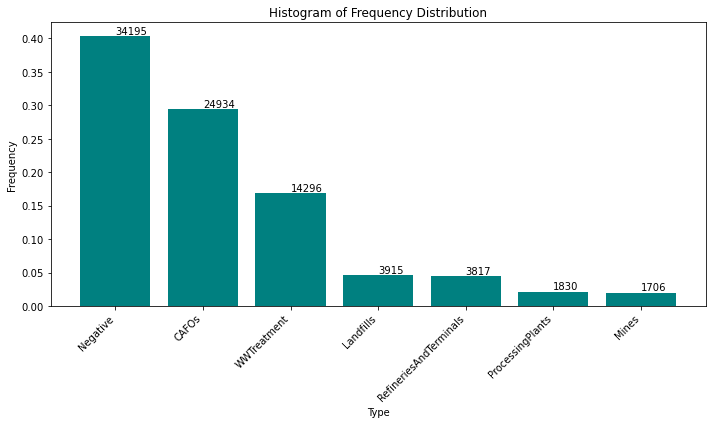

In [5]:
#group to count label occurence
train_dist = train.groupby("Type").count().reset_index()
train_dist_v2 = train_dist[["Type", "Type_encoded"]]
train_dist_v2 = train_dist_v2.sort_values("Type_encoded", ascending=False)


#count the number of rows in the dataset
n = train.shape[0]

#calculate the realtive frequency of each label
train_dist["Frequency"] = train_dist["Type_encoded"]/n
train_dist = train_dist[["Type", "Frequency"]].sort_values("Frequency", ascending=False)
train_dist


#display histogram of the distribution
plt.figure(figsize=(10, 6))
bars = plt.bar(train_dist['Type'], train_dist['Frequency'], color='teal')

#add counts above the bars
for bar, count in zip(bars, train_dist_v2['Type_encoded']):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, count, va='bottom')  # va='bottom' to place text above the bar

plt.title('Histogram of Frequency Distribution')
plt.xlabel('Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

This shows a significant imbalance which needs to be coped with.

Based on the absolute numbers above, 10.000 instances per label seems like a reasonable quantity.

## Setting up the Balancing

In [6]:
#number of needed instances per label
x = 10000

train_count = train_dist_v2.rename(columns={"Type_encoded": "Count"})

#calculate the deficit or surplus of instances per label
train_count["Deficit"] = x - train_count["Count"]
#need for augmentation if deficit is positive
train_count["Augment"] = [False if deficit < 0 else True for deficit in train_count["Deficit"]]
#
train_count["Factor"] = [round(x/c, 2) for aug, c, d in zip(train_count["Augment"], train_count["Count"], train_count["Deficit"])]

train_count



,Type,Count,Deficit,Augment,Factor
3,Negative,34195,-24195,False,0.29
0,CAFOs,24934,-14934,False,0.40
6,WWTreatment,14296,-4296,False,0.70
1,Landfills,3915,6085,True,2.55
5,RefineriesAndTerminals,3817,6183,True,2.62
4,ProcessingPlants,1830,8170,True,5.46
2,Mines,1706,8294,True,5.86


In [7]:
# Function to calculate average brightness
def calculate_brightness(image):
    grayscale_image = image.convert("L")
    pixel_values = np.array(grayscale_image)
    return np.mean(pixel_values)

# Function to calculate contrast
def calculate_contrast(image):
    grayscale_image = image.convert("L")
    stat = ImageStat.Stat(grayscale_image)
    return stat.stddev[0]

# Create a list to store filenames that need to be removed
files_to_remove = []

# Process each blob
blobs = container_client.list_blobs()
for blob in blobs:
    if blob.name.endswith(".jpg") and blob.name.startswith("samples/train_images"):
        print(f"Processing {blob.name}")
        blob_client = container_client.get_blob_client(blob.name)
        blob_data = blob_client.download_blob().readall()
        image_data = io.BytesIO(blob_data)
        image = Image.open(image_data)

        # Calculate brightness and contrast
        brightness = calculate_brightness(image)
        contrast = calculate_contrast(image)

        print(f"Brightness: {brightness}, Contrast: {contrast}")

        # Check if the image meets the removal criteria
        if brightness < 60 or contrast < 30:
            files_to_remove.append(blob.name)

print("Number of images to remove due to low quality: ", len(files_to_remove))

Number of images to remove due to low quality:  0


Since there are no images of low quality, as can be seen above, there must not be any additional cleaning of the dataset.

The Factor represents the multiplicator necessary to bring the sample size to ~10000.


In [8]:
def downsample(df, metadata):
    ds = pd.DataFrame(columns=['Image_Folder', 'Type', 'Type_encoded'])

    meta_ds = metadata[metadata["Augment"] == False]
    labels = meta_ds['Type'].unique().tolist()

    for label in labels:
        #just use data of certian label
        df_label = df[df["Type"] == label]
        
        #keep 8000 rows
        down_samp = df_label.sample(n=8000, random_state=42)

        #add the downsampled data to the dataset
        ds = pd.concat([ds, down_samp], ignore_index=True)

    return ds

downsampled = downsample(train, train_count)
downsampled

downsampled.to_csv('METER_ML_train_downsampled.csv', index=False)


In [16]:
df = pd.read_csv('METER_ML_train_downsampled.csv')

# Count the occurrence of each type in the CSV
type_counts = df['Type'].value_counts()

# Calculate how many more images are needed to reach 10,000 for each type
needed_augmentations = 10000 - type_counts

# Convert needed_augmentations to a dictionary for easier manipulation
needed_augmentations = needed_augmentations.to_dict()

# Initialize a dictionary to track the number of augmented images
augmented_counts = {type: 0 for type in needed_augmentations}

# Initialize the DataFrame index for iteration
index = 0
max_index = len(df) - 1

def horizontal_flip(image):
    return cv2.flip(image, 1)

def vertical_flip(image):
    return cv2.flip(image, 0)

def rotate_90_clockwise(image):
    return cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)

def increase_brightness_and_saturation(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv_image[:, :, 1] += 25  # Add to saturation
    hsv_image[:, :, 2] += 15  # Add to brightness
    hsv_image = np.clip(hsv_image, 0, 255)
    return cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)

def add_gaussian_noise(image):
    noise = np.random.normal(loc=0.0, scale=25.0, size=image.shape)
    noisy_image = image.astype(np.float32) + noise
    noisy_image = np.clip(noisy_image, 0, 255)
    return noisy_image.astype(np.uint8)

def random_augment(image):
    methods = [
        horizontal_flip,
        vertical_flip,
        rotate_90_clockwise,
        increase_brightness_and_saturation,
        add_gaussian_noise
    ]

    try:
        # Randomly choose two different methods and apply them sequentially
        chosen_methods = random.sample(methods, 2)
        augmented_image = chosen_methods[0](image)
        augmented_image = chosen_methods[1](augmented_image)

        # Check if the augmentation resulted in an empty image
        if augmented_image.size == 0:
            print("Augmentation resulted in an empty image.")
            return None
        return augmented_image
    except Exception as e:
        print(f"An error occurred during augmentation: {str(e)}")
        return None

# Function to randomly augment image
#def random_augment(image):
    # Define augmentation methods
#    methods = [
#        lambda image: cv2.flip(image, 1),  # Horizontal flip
#        lambda image: cv2.flip(image, 0),  # Vertical flip
#        lambda image: cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE),  # Rotate 90 degrees
#        lambda image: cv2.cvtColor(cv2.add(cv2.cvtColor(image, cv2.COLOR_RGB2HSV), np.array([15, 25, 0])), cv2.COLOR_HSV2RGB),  # Increase brightness and saturation
#        lambda image: (image.astype(np.float32) + np.random.normal(loc=0.0, scale=25.0, size=image.shape)).clip(0, 255).astype(np.uint8)  # Add Gaussian noise
#    ]
    # Randomly select two different augmentation methods
#    chosen_methods = random.sample(methods, 2)
    
    # Apply the two chosen methods sequentially
#    augmented_image = chosen_methods[0](image)
#    augmented_image = chosen_methods[1](augmented_image)

# Function to upload a png file to Azure Blob Storage with a given folder name
def upload_png_to_blob(image, file_name):
    blob_name = f"augmented_final/{file_name}"
    blob_client = container_client.get_blob_client(blob_name)
    success, encoded_image = cv2.imencode('.png', image)
    if not success:
        print(f"Error encoding image: {file_name}")
        return None
    try:
        blob_client.upload_blob(encoded_image.tobytes(), overwrite=True)
        return blob_name, image_type
    except Exception as e:
        print(f"Error uploading image {file_name} to blob: {str(e)}")
        return None

# Initialize a global counter for augmented images
augmented_image_counter = 0

# Main loop
while any(count < needed_augmentations[type] for type, count in augmented_counts.items()):
    row = df.iloc[index]
    image_type = row['Type']
    file_name = row['Image_Folder']
    file_path = file_name  # Adjust based on actual path format in CSV

    if augmented_counts[image_type] < needed_augmentations[image_type]:
        # Image processing and augmentation logic
        blob = container_client.download_blob(file_path).readall()
        nparr = np.frombuffer(blob, np.uint8)
        image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

        if image is None or image.size == 0:
            print(f"Error: Failed to decode image from blob storage for path {file_path}")
        else:
            augmented_image = random_augment(image)
            if augmented_image is not None and augmented_image.size != 0:
                augmented_file_name = f"{augmented_image_counter:05}.png"
                # Upload the augmented image back to blob
                result = upload_png_to_blob(augmented_image, augmented_file_name)
                if result:
                    blob_name, image_type = result
                    print(f"Uploaded: {blob_name}, Type: {image_type}")
                augmented_image_counter += 1
                augmented_counts[image_type] += 1

    # Increment or reset index
    index += 1
    if index > max_index:
        index = 0  # Reset index to loop over the DataFrame again

print("Augmentation process completed.")

#save the new resulting datframe to excel
result.to_csv('FINAL_METER_ML_train_v2.csv', index=False)
result

Uploaded: augmented_final/00000.png, Type: Negative
Uploaded: augmented_final/00001.png, Type: Negative
Uploaded: augmented_final/00002.png, Type: Negative
Uploaded: augmented_final/00003.png, Type: Negative
Uploaded: augmented_final/00004.png, Type: Negative
Uploaded: augmented_final/00005.png, Type: Negative
Uploaded: augmented_final/00006.png, Type: Negative
Uploaded: augmented_final/00007.png, Type: Negative
Uploaded: augmented_final/00008.png, Type: Negative
Uploaded: augmented_final/00009.png, Type: Negative
Uploaded: augmented_final/00010.png, Type: Negative
Uploaded: augmented_final/00011.png, Type: Negative
Uploaded: augmented_final/00012.png, Type: Negative
Uploaded: augmented_final/00013.png, Type: Negative
Uploaded: augmented_final/00014.png, Type: Negative
Uploaded: augmented_final/00015.png, Type: Negative
Uploaded: augmented_final/00016.png, Type: Negative
Uploaded: augmented_final/00017.png, Type: Negative
Uploaded: augmented_final/00018.png, Type: Negative
Uploaded: au